# Build an interface between deepXDE and Altair Simulation

In [1]:
import numpy as np
import pandas as pd
import pyvista as pv
import deepxde as dde

from pinnDSE.geom import MeshGeom
from pinnDSE.viz import *
from pinnDSE.elasticity import *
from pinnDSE.bc import *

Using TensorFlow 2 backend.

Instructions for updating:
non-resource variables are not supported in the long term


2 read mesh: 0.02892279624938965


3 coordinate transform: 13.67682695388794
2 read results: 18.59504771232605
1 total mesh and result loading: 18.8674373626709
1 total edge processing: 0.8976306915283203


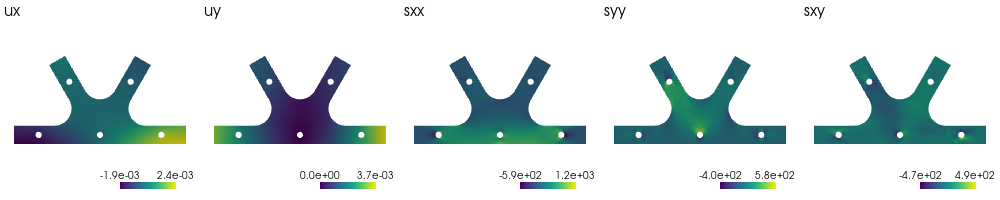

In [2]:
# load mesh and solver results
op2File = 'data/connector/v1.0/connectorDesign02.op2'
geom = MeshGeom(op2File, thickness=0.25)
plotScalarFields(geom.mesh, geom.resDf)

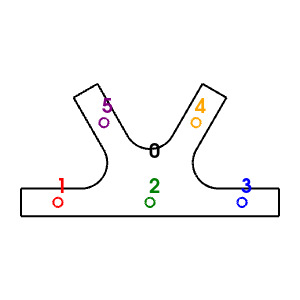

In [3]:
drawBoundaries(geom.bndDict)

Compiling model...
Building feed-forward neural network...
'build' took 0.059840 s



C:\Users\ewhalen\Miniconda3\envs\pinnDSE\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
C:\Users\ewhalen\Miniconda3\envs\pinnDSE\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 1.205775 s

Initializing variables...
Training model...

Step      Train loss                                                                                                                            Test loss                                                                                                                             Test metric
0         [4.15e-02, 2.75e-02, 1.94e+09, 1.19e+09, 4.90e+08, 3.20e-02, 3.97e-02, 9.07e-03, 6.84e-03, 1.72e+05, 2.49e-04, 2.05e-02, 6.53e-03]    [4.32e-02, 2.80e-02, 1.96e+09, 1.23e+09, 5.00e+08, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
100       [1.97e-02, 3.06e-02, 1.13e+06, 1.24e+05, 9.64e+04, 6.56e-06, 2.75e-04, 7.28e-03, 8.36e-03, 1.72e+05, 2.82e-04, 9.76e-03, 1.32e-02]    [2.04e-02, 3.11e-02, 9.03e+05, 1.36e+05, 8.75e+04, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  

Best model at step 100:
  train loss: 1.52e+06
  test loss: 1.13e+06
  

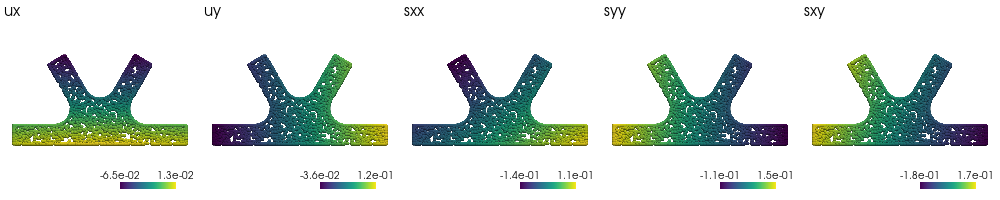

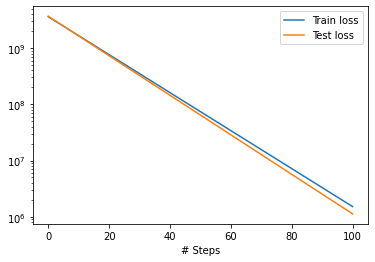

In [4]:
# supports
xBc = SupportBC(geom, bndId=1, U=0, component=0)
yBc = SupportBC(geom, bndId=1, U=0, component=1)

# traction free edges
xTr0 = TractionBC(geom, bndId=0, T=0, component=0)
yTr0 = TractionBC(geom, bndId=0, T=0, component=1)
xTr3 = TractionBC(geom, bndId=3, T=0, component=0)
yTr3 = TractionBC(geom, bndId=3, T=0, component=1)

# external loads
Fx = 22 # N
xTr2 = TractionBC(geom, bndId=2, T=Fx/geom.bndAreaDict[2], component=0)
yTr2 = TractionBC(geom, bndId=2, T=0, component=1)

# problem setup
# bndNumSamplesDir = {0:800, 1:50, 2:50, 3:50}
bndNumSamplesDir = {bndId:int(l*100) for bndId,l in geom.bndLensDict.items()}
paramDict = {'E':2e5, 'nu':0.3}
bcList = [xBc,yBc,xTr0,yTr0,xTr2,yTr2,xTr3,yTr3]
data = StrctPDE(geom, 
            elasticityEqs, 
            bcList, 
            num_domain=1000, 
            num_boundary_dir=bndNumSamplesDir, 
            num_test=500,
            paramDict=paramDict)

for bc in bcList:
    if isinstance(bc, TractionBC): 
        bc.train_n = data.train_n

# train
net = dde.maps.FNN([2] + [64]*4  + [5], "tanh", "Glorot uniform")
model = dde.Model(data, net)
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=100, display_every=100)
dde.postprocessing.plot_loss_history(losshistory)

# test
pred = model.predict(data.train_x)
predDf = pd.DataFrame(pred, columns=['ux', 'uy', 'sxx', 'syy', 'sxy'])
pc = pv.PolyData(addZ(data.train_x))
plotScalarFields(pc, predDf)

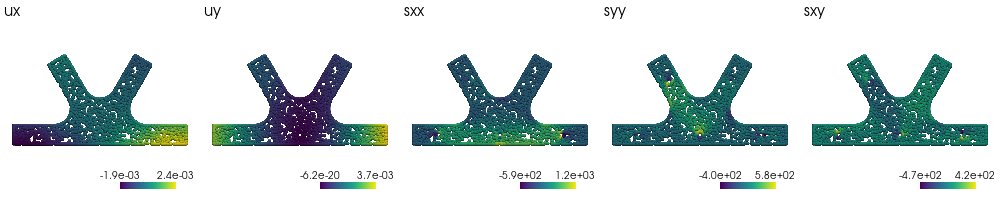

In [5]:
intResDf = geom.sampleRes(data.train_x)
plotScalarFields(pc, intResDf)

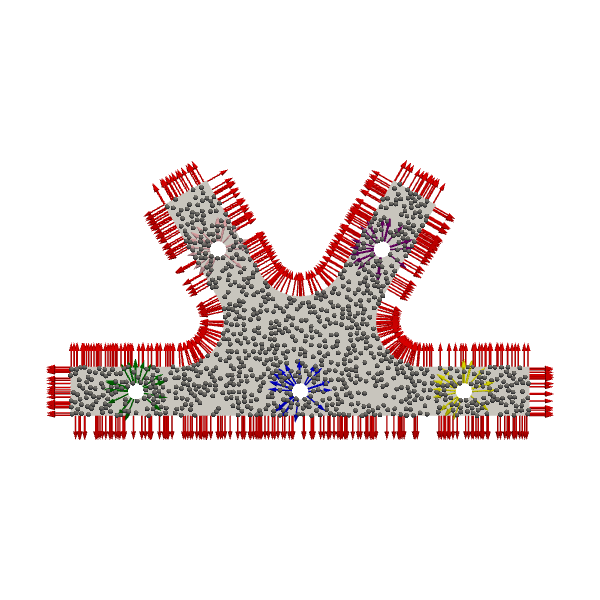

In [6]:
plotter = pv.Plotter(border=False)
plotter.set_background('white')
plotter.add_mesh(geom.mesh, show_edges=False)

# domain samples
pc = pv.PolyData(addZ(data.domainSamples))
plotter.add_mesh(pc, render_points_as_spheres=True, color='gray')


# boundary samples
colors = ['red', 'green', 'blue', 'yellow', 'purple', 'pink']
for bndId, color in zip(geom.bndDict.keys(), colors):
    samples = addZ(data.bndSampleDict[bndId])
    normals = addZ(data.bndNormalsDict[bndId])
    plotter.add_arrows(samples, normals, 0.1, color=color)
plotter.show(window_size=(600,600), cpos='xy');